### GBM & Classification

Welcome to today's class!  In this lesson we'll continue our discussion of modeling on tabular data, but we're going to extend our toolbelt in two different ways:

 - We're going to work with a **classification** problem, as opposed to a regression problem
 - We're going to work with a **more advanced** gradient boosted model that will give us superior results

### Classification:

 - The target variable is a categorical variable, as opposed to a numeric one
 - Therefore we are predicting **probability**, rather than a raw number
 
 <img src="gbm1.JPG"></img>

### Predicted Values Look Like This

<img src="gbm2.jpg"></img>

### How Is Classification Different?

Common issues when dealing with classification:

 - How well does your model handle each of the individual classes?
 - What if your dataset is very lopsided?  (ie, 99.5 % of the samples belong to a particular class?)
 - What metric can you use to gauge how you're doing across all possible classes? (Accuracy is not always the best metric)

### Some Common Solutions:

 - You assign different weights to different classes
   - ie, you make success or failure count more, depending on which one you care most about
 - You use **stratified** cross validation -- equal proportion of classes in every single split
 - Different error metrics do a better job of blending how you do in predicting each class, for both positive and negative outcomes

### Why Move Past Scikit Learn?

 - Great Library
 - Very well engineered, clean API
 - Covers Lots of useful areas of ML
 - Has a few weaknesses:
  - Doesn't make the best use of modern computing architectures
  - Doesn't run on a GPU
  - ML moves so fast that more advanced techniques crop up faster than can be implemented into the main library
  - Beginning to suffer from the craigslist effect
  
<img src="gbm3.jpg"></img>

### Enter XGBoost

<img src="gbm4.png"></img>

 - Specialized gradient boosting library built in 2014
 - Has many advantages over Scikit-Learn implementation:
  - Does not need missing values imputed
  - ~ 30 % faster due to ability of trees to be created across multiple computers
  - Runs on GPU
  - Uses different splitting criteria that give it more accurate results
 - Has a Scikit-Learn wrapper to make the coding exactly the same
 - Most commonly used GBM implementation among companies doing production level ML

### Our Task:  What Are The Chances of Your Kickstarter Campaign Being Funded?

In [120]:
# let's import libraries
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
# this is the file you should've gotten from your repo
from utils import extract_dates, get_val_scores
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split

In [112]:
df = pd.read_csv('ks2.csv', encoding='utf-8', parse_dates=['deadline', 'launched'])
df.head()

,ID,name,category,main_category,currency,deadline,launched,state,country,goal
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,GB,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,US,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,US,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,US,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,failed,US,19500.00


### What We're Going To Do:

 - Refine our technique for building, validating, and visualizing models
 - Get practice going over some techniques covered in Unit 2  - grouping, merging, summary statistics, etc
 - Get a first look at XGBoost and how it compares to SKLearn

In [3]:
# first, let's take a look at a function we're going to use today
??extract_dates

In [3]:
# this will pull out every possible date part of every date column within your dataset
df = extract_dates(df)
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'launched', 'state', 'country', 'goal', 'deadline_dayofweek',
       'deadline_dayofyear', 'deadline_days_in_month', 'deadline_is_leap_year',
       'deadline_is_month_end', 'deadline_is_month_start',
       'deadline_is_quarter_end', 'deadline_is_quarter_start',
       'deadline_is_year_end', 'deadline_is_year_start', 'deadline_quarter',
       'deadline_week', 'deadline_weekofyear', 'deadline_day', 'deadline_hour',
       'deadline_minute', 'deadline_month', 'deadline_year',
       'launched_dayofweek', 'launched_dayofyear', 'launched_days_in_month',
       'launched_is_leap_year', 'launched_is_month_end',
       'launched_is_month_start', 'launched_is_quarter_end',
       'launched_is_quarter_start', 'launched_is_year_end',
       'launched_is_year_start', 'launched_quarter', 'launched_week',
       'launched_weekofyear', 'launched_day', 'launched_hour',
       'launched_minute', 'launched_month', 'laun

In [4]:
# let's initialize our XGB model 
mod1 = xgb.XGBClassifier()

In [6]:
# this is the Scikit-Learn wrapper -- syntax is exactly the same as what we've used before
mod1.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [5]:
# let's go ahead and create a pipeline
pipe = make_pipeline(OrdinalEncoder(), mod1)

In [6]:
# let's do an initial checking of our validation set
X = df.drop(['deadline', 'launched', 'state'], axis=1)
y = df['state']

In [9]:
# let's take a look at the arguments we can use for get_val_scores
?get_val_scores

In [7]:
# get an initial score for our model, with feature importances
scores = get_val_scores(pipe, X, y, return_test_score=True, random_state=1985, stratify=True, use_kfold=False)

In [9]:
# the validation scores look good
scores

{'validation_score': 0.6857085013412515, 'test_score': 0.6892874978067511}

In [8]:
# let's take a look at feature importances
feats = pd.DataFrame({ 'Importance': pipe.steps[1][1].feature_importances_, 'Column': X.columns})
feats.sort_values(by='Importance', ascending=False)

,Importance,Column
6,0.207080,goal
43,0.102636,deadline_history_days
2,0.093736,category
3,0.083528,main_category
39,0.063676,launched_hour
40,0.062726,launched_minute
7,0.051011,deadline_dayofweek
4,0.049180,currency
44,0.043757,launched_history_days
9,0.037466,deadline_days_in_month


### Feature Engineering!

In [10]:
# how long is your campaign?
df['duration'] = (df['deadline'] - df['launched']).dt.days

### Summary Statistics

Let's look at how the goal amount of each campaign compared to the category that it belonged to.

In [11]:
# get the average goal for each category
category_avgs = df.groupby('category')[['goal']].mean().reset_index().rename({'goal': 'category_goal_avg'}, axis=1)

In [12]:
# and merge it back in with the original dataset
df = df.merge(category_avgs, on='category')

In [13]:
# and for each campaign get the percent of category average
df['cat_goal_pct'] = df['goal'] / df['category_goal_avg']

In [14]:
# and our results
df[['goal', 'category_goal_avg', 'cat_goal_pct']].head()

,goal,category_goal_avg,cat_goal_pct
0,1533.95,5213.996468,0.294199
1,6060.97,5213.996468,1.162442
2,2000.00,5213.996468,0.383583
3,10000.00,5213.996468,1.917915
4,757.52,5213.996468,0.145286


### Your Turn:  

Go through the same process, but this time, create two columns for the `main_category` feature:  it's average value, and the percent of average for each campaign

Take 5-7 minutes

In [15]:
# get the summary statistic
main_cats = df.groupby('main_category')[['goal']].mean().reset_index().rename({'goal': 'main_cat_goal_avg'}, axis=1)

In [16]:
# and merge it back in
df = df.merge(main_cats, on='main_category')

In [17]:
# and get the percent value
df['main_goal_pct'] = df['goal'] / df['main_cat_goal_avg']

In [18]:
# take a look
df[['goal', 'main_cat_goal_avg', 'main_goal_pct']].head()

,goal,main_cat_goal_avg,main_goal_pct
0,1533.95,22590.745149,0.067902
1,6060.97,22590.745149,0.268294
2,2000.00,22590.745149,0.088532
3,10000.00,22590.745149,0.442659
4,757.52,22590.745149,0.033532


In [19]:
# let's re-declare and run
X = df.drop(['deadline', 'launched', 'state'], axis=1)
y = df['state']

In [20]:
# refit
scores = get_val_scores(pipe, X, y, random_state=1985, stratify=True, use_kfold=False)

In [21]:
# and take a peek -- a **little** better
scores

{'validation_score': 0.6997621176589678}

### What About Campaign Traffic?

Other metrics that might be useful could be how busy Kickstarter was when you launched your campaign.  For example, if you launched your campaign during a week that's unusually slow, you might be more likely to be found by random backers.

We'll use similar feature engineering techniques to get at these values.

In [22]:
# we'll get the number of campaigns launched during a particular week on Kickstarter
weekly_sums = df.groupby(['launched_year', 'launched_weekofyear'])[['ID']].count().reset_index().rename({'ID': 'Weekly_Campaigns'}, axis=1)

In [23]:
# and merge back in
df = df.merge(weekly_sums, on=['launched_year', 'launched_weekofyear'])

In [24]:
# and our final results
df.head()

,ID,name,category,main_category,currency,deadline,launched,state,country,goal,...,launched_month,launched_year,deadline_history_days,launched_history_days,duration,category_goal_avg,cat_goal_pct,main_cat_goal_avg,main_goal_pct,Weekly_Campaigns
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,GB,1533.95,...,8,2015,2350,16658,58,5213.996468,0.294199,22590.745149,0.067902,1271
1,1403665672,Sentiments of a Sentimental Ol' Fool: A book t...,Poetry,Publishing,USD,2015-09-09,2015-08-10 17:36:06,failed,US,5000.00,...,8,2015,2320,16657,29,5213.996468,0.958957,22590.745149,0.221330,1271
2,1811433012,My first Poetry Book (Canceled),Poetry,Publishing,USD,2015-09-12,2015-08-13 05:08:15,failed,US,2000.00,...,8,2015,2323,16660,29,5213.996468,0.383583,22590.745149,0.088532,1271
3,75470413,The Circled Shore,Poetry,Publishing,USD,2015-09-11,2015-08-14 06:26:10,successful,US,3000.00,...,8,2015,2322,16661,27,5213.996468,0.575374,22590.745149,0.132798,1271
4,1053752807,The Armor Journal Magazine Goes In Print (Canc...,Nonfiction,Publishing,USD,2015-10-10,2015-08-11 07:45:32,failed,US,12000.00,...,8,2015,2351,16658,59,18906.372594,0.634707,22590.745149,0.531191,1271


### Your Turn

Perform this same task, but get the values for the following:

 - Number of campaigns launched on that particular **day**
 - Number of campaigns launched within a particular **category** in a particular week
 - Number of campaigns launched within a particular category in a particular day
 
Take 10 - 15 minutes

In [25]:
# the daily totals
daily_sums = df.groupby(['launched_year', 'launched_dayofyear'])[['ID']].count().reset_index().rename({'ID': 'Daily_Campaigns'}, axis=1)

In [26]:
# merge it back in
df = df.merge(daily_sums, on=['launched_year', 'launched_dayofyear'])

In [27]:
# weekly totals for a particular category
cat_weekly_sums = df.groupby(['category', 'launched_year', 'launched_weekofyear'])[['ID']].count().reset_index().rename({'ID': 'Cat_Weekly_Campaigns'}, axis=1)

In [28]:
# merge them back in
df = df.merge(cat_weekly_sums, on=['category', 'launched_year', 'launched_weekofyear'])

In [29]:
# daily totals for a particular category
cat_daily_sums = df.groupby(['category', 'launched_year', 'launched_dayofyear'])[['ID']].count().reset_index().rename({'ID': 'Cat_Daily_Campaigns'}, axis=1)

In [30]:
# and merge back in
df = df.merge(cat_daily_sums, on=['category', 'launched_year', 'launched_dayofyear'])

In [31]:
# let's re-declare X & y
X = df.drop(['deadline', 'launched', 'state'], axis=1)
y = df['state']

In [32]:
# and fit again
scores = get_val_scores(pipe, X, y, random_state=1985, stratify=True, use_kfold=False)

In [33]:
# these did not help, so we'll drop them
scores

{'validation_score': 0.6994584380746715}

In [34]:
# get rid of the columns
df.drop(['Daily_Campaigns', 'Cat_Weekly_Campaigns', 'Cat_Daily_Campaigns'], axis=1, inplace=True)

### What About The Name Column

Perhaps there are grammatical clues that can add predictive value to how likely a campaign is to succeed.  Perhaps people with better grammar are more likely to be conscientious and "have what it takes".  We'll go ahead and add in a few columns to find out.

In [36]:
# how long is the title?
df['name_length'] = df['name'].str.len()

In [37]:
# did they use all upper or lower cases?
df['name_upper_case'] = df['name'].str.isupper().astype(bool)
df['name_lower_case'] = df['name'].str.islower().astype(bool)

In [38]:
# Did they format it as a title?
df['name_is_title'] = df['name'].str.title().astype(bool)

In [39]:
# Did they use exclamation marks?
df['name_exclamation'] = df['name'].str.contains('!').astype(bool)

In [41]:
# refit and score
X = df.drop(['deadline', 'launched', 'state'], axis=1)
y = df['state']

In [42]:
# refit and score
scores = get_val_scores(pipe, X, y, random_state=1985, stratify=True, use_kfold=False)

In [43]:
# and this didn't seem to help either
scores

{'validation_score': 0.6972483255445143}

In [44]:
# so we'll drop
df.drop(['name_length', 'name_upper_case', 'name_lower_case', 'name_is_title', 'name_exclamation'], axis=1, inplace=True)

### Parameter Tuning

Now that we've found the most useful version of our dataset, we'll go ahead and find the best **parameters** for our model -- ie, aspects of the model that exist independently of the data itself.

Due to time constraints we'll limit ourselves to the depth of the trees, and the number of boosting rounds.

In [131]:
X = df.drop(['deadline', 'launched', 'state'], axis=1)
y = df['state']

In [133]:
# parameter tuning
max_depth = [3, 4, 5]
num_trees = [100, 200]
cv_scores = []

for depth in max_depth:
    for tree in num_trees:
        print(f"New round.  Depth: {depth}, Trees: {tree}")
        pipe.steps[1][1].set_params(max_depth=depth, n_estimators=tree)
        score = get_val_scores(pipe, X, y, use_kfold=False, stratify=True, random_state=1985)['validation_score']
        print(f"Score after fitting: {score}")
        cv_scores.append((score, depth, tree))

New round.  Depth: 3, Trees: 100
Score after fitting: 0.7006056720597912
New round.  Depth: 3, Trees: 200
Score after fitting: 0.7046041199196936
New round.  Depth: 4, Trees: 100
Score after fitting: 0.7063249708973731
New round.  Depth: 4, Trees: 200
Score after fitting: 0.7137145074485853
New round.  Depth: 5, Trees: 100
Score after fitting: 0.7080120796990198
New round.  Depth: 5, Trees: 200
Score after fitting: 0.719163868877904


In [46]:
# now let's fit on ALL of our training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1985)

In [136]:
# notice it's already set to our ideal parameters
pipe.steps[1][1].get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 200,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [137]:
# fit on ALL of the training set
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['name', 'category', 'main_category',
                                      'currency', 'country'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'name',
                                          'data_type': dtype('O'),
                                          'mapping': Ice Bunny                                                          1
700 Knights 2 of 4 - Let's Print                                   2
The Lil Trucker™                                                   3
Departure                                                          4
Billion Dollar Beauty Boom, a documentary on China'...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                           

In [138]:
# and finally score
pipe.score(X_test, y_test)

0.7105181466035011

### And What About SciKit Learn?

Here's a sample to demonstrate how the SciKit Learn implementation of GBM would have worked on the same dataset, with the same parameters

In [140]:
mod2 = GradientBoostingClassifier(n_estimators=200, max_depth=5)
pipe2 = make_pipeline(OrdinalEncoder(), mod2)

In [142]:
# fill in the missing values
X.fillna('Missing', inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1985)

In [143]:
# and finally we'll fit and score
pipe2.fit(X_train, y_train)
pipe2.score(X_test, y_test)

0.701893617308445

### Evaluating Classification Models

#### Common Issues With Classification Models:

 - Accuracy can be misleading metric:
  - Often care more about one class than the other
  - If classes are imbalanced, model can be accurate but useless
 - Positive category is often very small portion of overall samples (fraud, terrorists, clicks, etc)
 - Classification models often need to be tuned for criteria specific to the situation

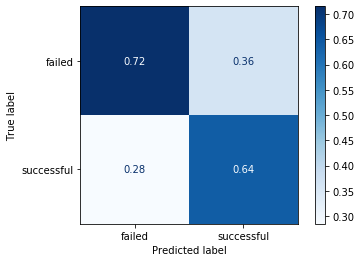

In [71]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

plot_confusion_matrix(pipe, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='pred');

In [75]:
# some more advanced metrics
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

      failed       0.72      0.88      0.79     47300
  successful       0.64      0.38      0.48     26791

    accuracy                           0.70     74091
   macro avg       0.68      0.63      0.63     74091
weighted avg       0.69      0.70      0.68     74091



$$ precision:  \frac{tp}{tp + fp}  $$

What it tells you:  if you predict 1, what are the chances that that prediction is correct?

$$ recall: \frac{tp}{tp + fn} $$

What it tells you -- for all of the existing instances of an item out there, how likely are you to detect it?

$$ f1 score:  \frac{precision * recall}{precision + recall} * 2 $$

A way of blending the two in a way that optimizes the two concurrently.

In [84]:
from sklearn.metrics import f1_score

y_true = np.where(y_test == 'successful', 1, 0)
y_pred = np.where(pipe.predict(X_test) == 'successful', 1, 0)
# our f1 score
f1_score(y_true, y_pred)

0.47956275984491054

### Second Issue:  What If Classes Are Heavily Imbalanced?

Key GBM parameter:  `scale_pos_weight`

In [85]:
pipe.steps[1][1].get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

 - Tells you how much to weight positive samples relative to negative ones
 - Default is 1:1
 - If value is set to 10, means loss from incorrectly classifying label 1 will count 10x as much as incorrectly classifying negative label
 - Good rule of thumb:  set the value to the inverse of class proportion
 - Ie, successful campaigns are 1/3 of the data, so set pos_scale_weight to 3

In [96]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1985)

In [99]:
# can we optimize the value of the positive weight?
pipe.fit(X_train, y_train)
y_true = np.where(y_test == 'successful', 1, 0)
y_pred = np.where(pipe.predict(X_test) == 'successful', 1, 0)
f1_score(y_true, y_pred)

0.48471210504338147

### Your Turn:  Let's Try And Find the Ideal Values of `scale_pos_weight` for our dataset, using an F1 Score.

Use the value of 1, 2, 3, 4

In [102]:
weight_values = [1, 2, 3, 4]
cv_scores  = []

for weight in weight_values:
    print(f"Testing the validation score for weighting of: {weight}")
    pipe.steps[1][1].set_params(scale_pos_weight=weight)
    pipe.fit(X_train, y_train)
    y_true = np.where(y_test == 'successful', 1, 0)
    y_pred = np.where(pipe.predict(X_test) == 'successful', 1, 0)
    val_score = f1_score(y_true, y_pred)
    print(f"Validation score: {val_score}")
    cv_scores.append((val_score, weight))
    
top_score = max(cv_scores)
pipe.steps[1][1].set_params(scale_pos_weight=top_score[1])

Testing the validation score for weighting of: 1
Validation score: 0.48471210504338147
Testing the validation score for weighting of: 2
Validation score: 0.6161128894098552
Testing the validation score for weighting of: 3
Validation score: 0.6045754090556016
Testing the validation score for weighting of: 4
Validation score: 0.5871856135369414


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, seed=None,
              silent=None, subsample=1, verbosity=1)

In [113]:
X_train = pd.concat([X_train, X_val])
y_train = pd.concat([y_train, y_val])

(355636,)

In [117]:
pipe.fit(X_train, y_train)
y_true = np.where(y_test == 'successful', 1, 0)
y_pred = np.where(pipe.predict(X_test) == 'successful', 1, 0)
test_score = f1_score(y_true, y_pred)
test_score

0.6162648878984536